# Post-operative prediction using Bayesian Networks
FAIKR module 3 project, done by Michele Calvanese, Samuele Marino  

## Introduction

Postoperative patient care has several components: - surveillance, − prevention of complications associated with surgical disease or other preexisting comorbidities, − specific postoperative treatment of the surgical disease and its complications. While these distinctions are purely didactic, the postoperative care merges into an active surveillance with a higher level of standardization than it would seem at first glance.

The goal of this project is to determine where patients in a postoperative recovery area should be sent to next. Because hypothermia is a significant concern after surgery, the attributes correspond roughly to body temperature measurements.

Number of Instances: 90

Number of Attributes: 9 including the decision (class attribute)

Attribute Information:
1. L-CORE (patient's internal temperature in C):
              high (> 37), mid (>= 36 and <= 37), low (< 36)
2. L-SURF (patient's surface temperature in C):
              high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)
3. L-O2 (oxygen saturation in %):
              excellent (>= 98), good (>= 90 and < 98),
              fair (>= 80 and < 90), poor (< 80)
4. L-BP (last measurement of blood pressure):
              high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)
5. SURF-STBL (stability of patient's surface temperature):
              stable, mod-stable, unstable
6. CORE-STBL (stability of patient's core temperature)
              stable, mod-stable, unstable
7. BP-STBL (stability of patient's blood pressure)
              stable, mod-stable, unstable
8. COMFORT (patient's perceived comfort at discharge, measured as
              an integer between 0 and 20)
9. decision ADM-DECS (discharge decision):
              I (patient sent to Intensive Care Unit),
              S (patient prepared to go home),
              A (patient sent to general hospital floor)


Dataset [link](https://archive.ics.uci.edu/ml/datasets/Post-Operative+Patient).

In [233]:
import pandas as pd
import numpy as np
import pgmpy
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, BDsScore, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator, BayesianEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout


## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, all the attributes need to be discretized, as the pgmpy library only works with discrete variables.

In [234]:
path = "./Dataset/post-operative.data"
attributes = ['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL', 'COMFORT', 'ADM-DECS']
data = pd.read_csv(path, sep=',', header=None, names=attributes)
data.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,ADM-DECS
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


Verify the value of all attributes

In [235]:
for attribute in data.columns:
    print(attribute, ':', data[attribute].unique())

L-CORE : ['mid' 'high' 'low']
L-SURF : ['low' 'high' 'mid']
L-O2 : ['excellent' 'good']
L-BP : ['mid' 'high' 'low']
SURF-STBL : ['stable' 'unstable']
CORE-STBL : ['stable' 'unstable' 'mod-stable']
BP-STBL : ['stable' 'mod-stable' 'unstable']
COMFORT : ['15' '10' '05' '07' '?']
ADM-DECS : ['A' 'S' 'A ' 'I']


In attribute ``ADM-DECS`` there are same incorrect values. So i replace the 'A ' values with 'A'

In [236]:
data = data.replace({'A ': 'A'})
data['ADM-DECS'].unique()

array(['A', 'S', 'I'], dtype=object)

Also in ``COMFORT`` there are inconsistent value, for thise reason I remove all the row where '?' is present

In [237]:
data = data.drop(data[data.COMFORT == '?'].index)

data['COMFORT'] = pd.cut(x=data['COMFORT'].astype(int),
                         bins=[0, 5, 10, 15, 20],
                         labels=["low_range", "normal_range", "medium_range", "high_range"])

data['COMFORT'].unique()

['medium_range', 'normal_range', 'low_range']
Categories (4, object): ['low_range' < 'normal_range' < 'medium_range' < 'high_range']

Before modifying the variables, dataset is checked for the presence of N/A values.

In [238]:
data.isnull().sum()

L-CORE       0
L-SURF       0
L-O2         0
L-BP         0
SURF-STBL    0
CORE-STBL    0
BP-STBL      0
COMFORT      0
ADM-DECS     0
dtype: int64

So there is no N/A values

Show the number of samples after the cline up

In [239]:
data.shape

(87, 9)

In [240]:
data.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,ADM-DECS
0,mid,low,excellent,mid,stable,stable,stable,medium_range,A
1,mid,high,excellent,high,stable,stable,stable,normal_range,S
2,high,low,excellent,high,stable,stable,mod-stable,normal_range,A
3,mid,low,good,high,stable,unstable,mod-stable,medium_range,A
4,mid,mid,excellent,high,stable,stable,stable,normal_range,A


##  Bayesian Network

### Learning the structure of the network and analyzing it 

One option for defining the structure of the network would be to manually add the nodes and connections between them. Knowing the connections between nodes requires having a sufficient knowledge about the field of application in order to be able to define conditional independence assertions. 

Luckily, pgmpy library offers many ways for learning a structure for discrete, fully observed networks. Given a set of data samples, the algorithm estimates a directed acyclic graph that captures dependencies between the variables. We will use Score-based structure estimation that learns the model as an optimization task, and which lets the programmer choose a search strategy and a scoring function which will be used.

Some of the available search strategies are:

- Exhaustive search
- Hill Climb search

The search space is super-exponential in the number of variables, which is the reason why Exhaustive search wasn't chosen for this particular project. However, for a very small number of nodes, it is guaranteed to find the best-scoring graph. When networks are bigger it is better to use Hill Climb search, which implements a greedy local search starting usually from a disconnected graph. In every iteration it makes one change on edges of the graph that maximally increases the score.

However, this approach often leads to inconsistent results: the node ADM-DECS may have exiting edges (which we do not want, because this is the attribute we want to predict), or multiple disconnected graphs may be found. We therefore remove all the edges that have ADM-DECS as parent and the ones that have Age as child. In addition, according to scientific medical sources [[link1](https://www.intechopen.com/chapters/76686), [link2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2582826/), [link3](https://bmcnurs.biomedcentral.com/articles/10.1186/1472-6955-11-24)], we force the learning algorithm to include the following edges in the network: ('BP-STBL', 'ADM-DECS'), ('L-O2', 'ADM-DECS'), ('SURF-STBL', 'ADM-DECS').


In [241]:
black_list = [('ADM-DECS', attribute) for attribute in data.columns[:-1]]
fixed_attributes = ['BP-STBL', 'L-O2', 'SURF-STBL']
fixed_edges = [(attribute, 'ADM-DECS') for attribute in fixed_attributes]


#learning the stucutre of the network
est = HillClimbSearch(data, use_cache=False)
best_model = est.estimate(scoring_method=K2Score(data),
                          black_list=black_list,
                          fixed_edges=fixed_edges
                          )


  0%|          | 6/1000000 [00:01<77:33:27,  3.58it/s] 


In [242]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)

#nodes of the model
model.nodes

NodeView(('L-CORE', 'BP-STBL', 'L-SURF', 'SURF-STBL', 'L-O2', 'ADM-DECS', 'L-BP', 'CORE-STBL', 'COMFORT'))

In [243]:
#edges of the model
model.edges

OutEdgeView([('L-CORE', 'BP-STBL'), ('BP-STBL', 'ADM-DECS'), ('L-SURF', 'SURF-STBL'), ('SURF-STBL', 'ADM-DECS'), ('L-O2', 'ADM-DECS'), ('L-BP', 'BP-STBL'), ('CORE-STBL', 'SURF-STBL'), ('CORE-STBL', 'L-O2'), ('COMFORT', 'L-O2')])

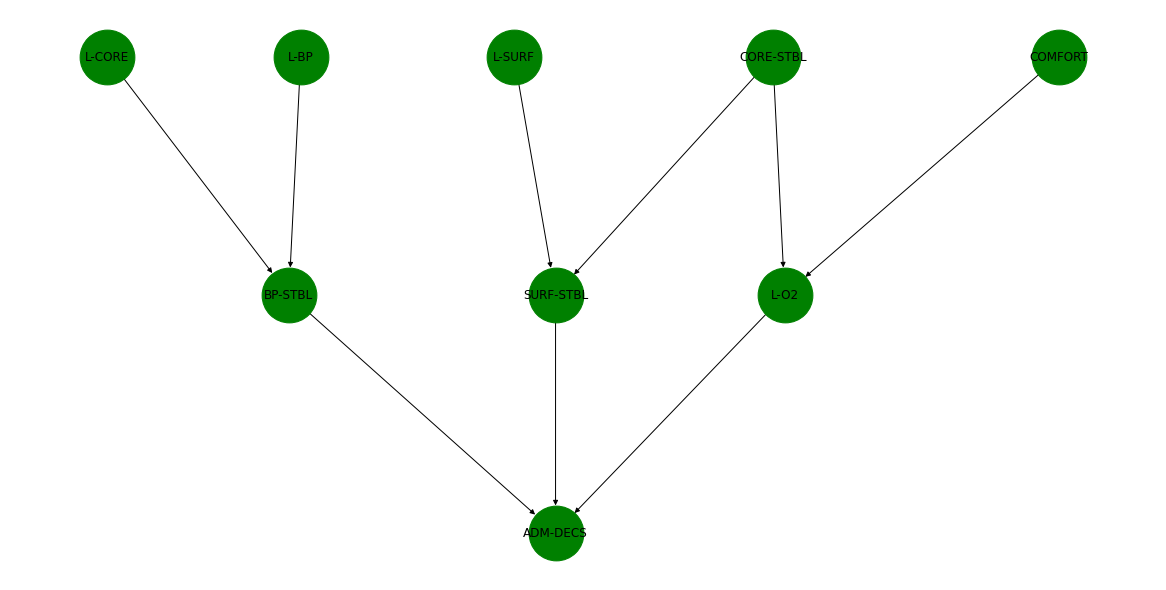

In [244]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(16, 8))
nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
plt.savefig('model.png')
plt.show()

### Learning the parameters of the network

As mentioned before, pgmpy currently supports parameter learning only for networks with discrete nodes. There are 2 available methods for determining the values of the conditional probability distributions:
- Maximum Likelihood estimation.

       This method uses relative frequencies for estimating conditional probabilities. However, in case of small datasets it is prone to overfitting.
- Bayesian estimation.

       On the other hand, Bayesian estimator assumes prior CPDs on variables and then updates them using state counts from observed data.
Because our dataset has only 116 samples we use __Bayesian estimation__

In [245]:
model.fit(data=data, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, 2*'\n', 80*"=", '\n')


CPT of L-CORE:
+--------------+----------+
| L-CORE(high) | 0.148551 |
+--------------+----------+
| L-CORE(low)  | 0.213768 |
+--------------+----------+
| L-CORE(mid)  | 0.637681 |
+--------------+----------+ 


CPT of BP-STBL:
+---------------------+-----+---------------------+
| L-BP                | ... | L-BP(mid)           |
+---------------------+-----+---------------------+
| L-CORE              | ... | L-CORE(mid)         |
+---------------------+-----+---------------------+
| BP-STBL(mod-stable) | ... | 0.19132149901380668 |
+---------------------+-----+---------------------+
| BP-STBL(stable)     | ... | 0.5374753451676528  |
+---------------------+-----+---------------------+
| BP-STBL(unstable)   | ... | 0.27120315581854043 |
+---------------------+-----+---------------------+ 


CPT of L-SURF:
+--------------+----------+
| L-SURF(high) | 0.192029 |
+--------------+----------+
| L-SURF(low)  | 0.278986 |
+--------------+----------+
| L-SURF(mid)  | 0.528986 |
+-----------

Checking if it has errors

In [246]:
model.check_model()

True

Cardinality of all model nodes

In [247]:
model.get_cardinality()

defaultdict(int,
            {'L-CORE': 3,
             'BP-STBL': 3,
             'L-SURF': 3,
             'SURF-STBL': 2,
             'L-O2': 2,
             'ADM-DECS': 3,
             'L-BP': 3,
             'CORE-STBL': 3,
             'COMFORT': 3})

Checking the markov blanket for Classification  and Glucose

In [248]:
print("Markov blanket for variable:")
print("ADM-DECS: ", model.get_markov_blanket("ADM-DECS"))
print("L-O2: ", model.get_markov_blanket("L-O2"))

Markov blanket for variable:
ADM-DECS:  ['L-O2', 'SURF-STBL', 'BP-STBL']
L-O2:  ['BP-STBL', 'SURF-STBL', 'CORE-STBL', 'COMFORT', 'ADM-DECS']
